Data Preparation Adjust the rating on a 1-to-5 scale.

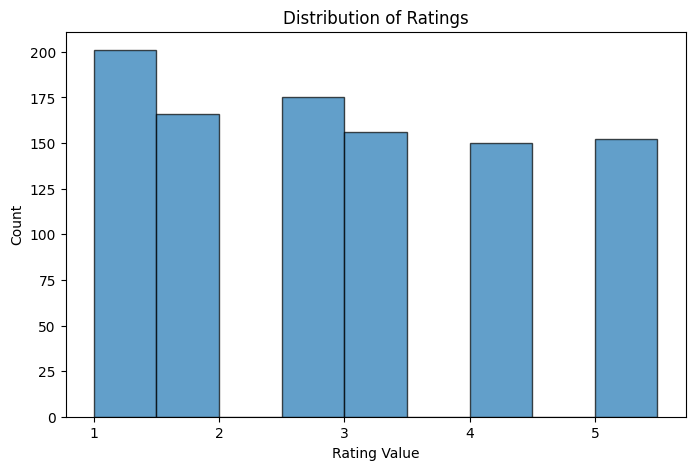

Sparsity: 0.00%
Mean ratings per item (sample):
Product_ID
4K TV                   2.648
Action Camera           2.904
Air Fryer               2.792
Bluetooth Headphones    3.096
Coffee Maker            2.936
dtype: float64
The two lowest-rated items are: ['Smart Speaker', '4K TV']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from Assignment 1
file_path = "item_based_matrix.csv"  # Update this to your file path
df = pd.read_csv(file_path)

# Ensure Product_ID is the index
df.set_index('Product_ID', inplace=True)

# Normalize the ratings to a 1-to-5 scale if not already done
def normalize_ratings(matrix):
    min_rating = matrix.min().min()
    max_rating = matrix.max().max()
    normalized = (matrix - min_rating) / (max_rating - min_rating) * 4 + 1
    return normalized

item_user_matrix = normalize_ratings(df)

# Save the dataset after normalization for reuse
item_user_matrix.to_csv("normalized_item_user_matrix.csv")

# Calculate total number of users and items
Tnu = item_user_matrix.shape[1]  # Number of columns (users)
Tni = item_user_matrix.shape[0]  # Number of rows (items)

# Count the number of ratings for each product
ratings_per_item = item_user_matrix.notna().sum(axis=1)

# Plot the distribution of ratings
plt.figure(figsize=(8, 5))
plt.hist(item_user_matrix.values.flatten(), bins=np.arange(1, 6, 0.5), edgecolor='black', alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Count")
plt.show()

# Check for sparsity
total_ratings = item_user_matrix.notna().sum().sum()
possible_ratings = Tnu * Tni
sparsity = 1 - (total_ratings / possible_ratings)
print(f"Sparsity: {sparsity * 100:.2f}%")

# Analyze bias
mean_rating_per_item = item_user_matrix.mean(axis=1)
print("Mean ratings per item (sample):")
print(mean_rating_per_item.head())

# Identify the two lowest-rated items
lowest_rated_items = mean_rating_per_item.nsmallest(2).index.tolist()
print(f"The two lowest-rated items are: {lowest_rated_items}")


Replacing Missing Values , Covariance Matrix and dtermining top 5-peers and  top 10-peers (3.2.1 to 3.2.7)



In [3]:
# Replace missing values with mean ratings (Mean-Filling Method)
mean_ratings = item_user_matrix.mean(axis=1)
mean_filled_matrix = item_user_matrix.copy()

for item in ['Smart Speaker', '4K TV']:
    mean_value = mean_ratings[item]
    mean_filled_matrix.loc[item] = mean_filled_matrix.loc[item].fillna(mean_value)

# Compute the differences between ratings and the mean rating for each item
mean_adjusted_matrix = mean_filled_matrix.sub(mean_ratings, axis=0)

# Compute the covariance for each pair of items
covariance_matrix = mean_adjusted_matrix.T.cov()

# Save the covariance matrix
covariance_matrix.to_csv("covariance_matrix.csv")

# Display the covariance matrix (sample)
print("Covariance Matrix (Sample):")
print(covariance_matrix.loc[['Smart Speaker', '4K TV'], ['Smart Speaker', '4K TV']])

# Determine the top 5 and top 10 peers for each target item
def get_top_peers(cov_matrix, target_item, n):
    sorted_peers = cov_matrix.loc[target_item].sort_values(ascending=False)
    return sorted_peers.index[1:n+1].tolist()  # Exclude the target item itself

top_5_peers = {item: get_top_peers(covariance_matrix, item, 5) for item in ['Smart Speaker', '4K TV']}
top_10_peers = {item: get_top_peers(covariance_matrix, item, 10) for item in ['Smart Speaker', '4K TV']}

# Display top peers
print("\nTop 5 Peers:")
print(top_5_peers)

print("\nTop 10 Peers:")
print(top_10_peers)


Covariance Matrix (Sample):
Product_ID     Smart Speaker     4K TV
Product_ID                            
Smart Speaker       1.345045 -0.092212
4K TV              -0.092212  2.100506

Top 5 Peers:
{'Smart Speaker': ['Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker', 'Office Chair'], '4K TV': ['Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle', 'Fitness Tracker']}

Top 10 Peers:
{'Smart Speaker': ['Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker', 'Office Chair', 'Smart Light Bulbs', 'Gaming Laptop', 'Wireless Mouse', 'VR Headset', 'Action Camera'], '4K TV': ['Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle', 'Fitness Tracker', 'Air Fryer', 'Smart Speaker', 'Action Camera', 'USB-C Charger', 'Gaming Monitor']}


rating predictions and comparison (3.2.8 to 3.2.12)

In [4]:
# Predict ratings using the top N peers
def predict_rating_with_peers(matrix, target_item, top_peers):
    predictions = {}
    for user in matrix.columns:
        if pd.isna(matrix.loc[target_item, user]):  # Only predict for missing ratings
            numerator = 0
            denominator = 0
            for peer in top_peers:
                if not pd.isna(matrix.loc[peer, user]):
                    weight = covariance_matrix.loc[target_item, peer]
                    numerator += weight * matrix.loc[peer, user]
                    denominator += abs(weight)
            predictions[user] = numerator / denominator if denominator != 0 else np.nan
    return predictions

# Simulate missing values for Smart Speaker and 4K TV
mean_filled_matrix.loc['Smart Speaker', ['User_1', 'User_5']] = np.nan
mean_filled_matrix.loc['4K TV', ['User_8', 'User_12']] = np.nan

# Predict ratings for Smart Speaker and 4K TV using top 5 and top 10 peers
predicted_ratings_top_5 = {item: predict_rating_with_peers(mean_filled_matrix, item, top_5_peers[item]) for item in ['Smart Speaker', '4K TV']}
predicted_ratings_top_10 = {item: predict_rating_with_peers(mean_filled_matrix, item, top_10_peers[item]) for item in ['Smart Speaker', '4K TV']}

# Display predictions
print("\nPredicted Ratings (Top 5 Peers):")
for item, predictions in predicted_ratings_top_5.items():
    print(f"Target Item: {item}")
    for user, rating in predictions.items():
        print(f"  User: {user}, Predicted Rating: {rating:.2f}")

print("\nPredicted Ratings (Top 10 Peers):")
for item, predictions in predicted_ratings_top_10.items():
    print(f"Target Item: {item}")
    for user, rating in predictions.items():
        print(f"  User: {user}, Predicted Rating: {rating:.2f}")

# Compare predictions between top 5 and top 10 peers
comparison_results = {item: {"Top 5": predicted_ratings_top_5[item], "Top 10": predicted_ratings_top_10[item]} for item in ['Smart Speaker', '4K TV']}
print("\nComparison of Predicted Ratings:")
for item, results in comparison_results.items():
    print(f"Target Item: {item}")
    print(f"  Top 5 Peers Predictions: {results['Top 5']}")
    print(f"  Top 10 Peers Predictions: {results['Top 10']}")



Predicted Ratings (Top 5 Peers):
Target Item: Smart Speaker
  User: User_1, Predicted Rating: 3.44
  User: User_5, Predicted Rating: 3.59
Target Item: 4K TV
  User: User_12, Predicted Rating: 4.55
  User: User_8, Predicted Rating: 3.24

Predicted Ratings (Top 10 Peers):
Target Item: Smart Speaker
  User: User_1, Predicted Rating: 3.52
  User: User_5, Predicted Rating: 3.44
Target Item: 4K TV
  User: User_12, Predicted Rating: 2.20
  User: User_8, Predicted Rating: 1.42

Comparison of Predicted Ratings:
Target Item: Smart Speaker
  Top 5 Peers Predictions: {'User_1': 3.435138020436175, 'User_5': 3.589110873875248}
  Top 10 Peers Predictions: {'User_1': 3.5244306618858414, 'User_5': 3.4399263494524654}
Target Item: 4K TV
  Top 5 Peers Predictions: {'User_12': 4.548471431583387, 'User_8': 3.243474594138731}
  Top 10 Peers Predictions: {'User_12': 2.200059880239521, 'User_8': 1.41814371257485}


Part2 Covariance Matrix (3.3.1)


In [5]:
# Compute Covariance Matrix
def compute_covariance_mle(matrix, debug=False):
    items = matrix.index
    covariance_mle = pd.DataFrame(0.0, index=items, columns=items)

    for i in items:
        for j in items:
            if i == j:
                covariance = matrix.loc[i].var()
            else:
                # Find common users for items i and j
                common_users = matrix.loc[[i, j]].dropna(axis=1)

                # Conditional debugging
                if debug and (i == "4K TV" or j == "Smart Speaker"):
                    print(f"Processing pair: ({i}, {j})")
                    print(f"Common users:\n{common_users}")

                if not common_users.empty:
                    covariance = common_users.loc[i].cov(common_users.loc[j])
                else:
                    covariance = 0

            covariance_mle.loc[i, j] = covariance

    return covariance_mle

# Run the function with debug=False to suppress logs
covariance_matrix_mle = compute_covariance_mle(item_user_matrix, debug=False)

# Display sample covariance matrix
print("Covariance Matrix (Sample):")
print(covariance_matrix_mle.loc[['Smart Speaker', '4K TV'], ['Smart Speaker', '4K TV']])


Covariance Matrix (Sample):
Product_ID     Smart Speaker     4K TV
Product_ID                            
Smart Speaker       1.345045 -0.092212
4K TV              -0.092212  2.100506


top 5-peers and top 10-peers for each target item using the covariance matrix 3.3.2.)

In [6]:
import pandas as pd

# Assuming covariance_matrix_mle is the covariance matrix computed in 3.3.1

# Define target items
target_items = ["Smart Speaker", "4K TV"]

# Find top 5 and top 10 peers
def find_top_peers(cov_matrix, target_items, top_n):
    top_peers = {}
    for item in target_items:
        # Sort items based on covariance values, exclude the item itself
        sorted_items = cov_matrix[item].sort_values(ascending=False)
        sorted_items = sorted_items.drop(item, errors='ignore')
        top_peers[item] = list(sorted_items.head(top_n).index)
    return top_peers

# Top 5 peers
top_5_peers = find_top_peers(covariance_matrix_mle, target_items, top_n=5)
print("Top 5 Peers:", top_5_peers)

# Top 10 peers
top_10_peers = find_top_peers(covariance_matrix_mle, target_items, top_n=10)
print("Top 10 Peers:", top_10_peers)

# Save the results for later use
saved_results = {
    "Top_5_Peers": top_5_peers,
    "Top_10_Peers": top_10_peers
}


Top 5 Peers: {'Smart Speaker': ['Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker', 'Office Chair'], '4K TV': ['Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle', 'Fitness Tracker']}
Top 10 Peers: {'Smart Speaker': ['Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker', 'Office Chair', 'Smart Light Bulbs', 'Gaming Laptop', 'Wireless Mouse', 'VR Headset', 'Action Camera'], '4K TV': ['Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle', 'Fitness Tracker', 'Air Fryer', 'Smart Speaker', 'Action Camera', 'USB-C Charger', 'Gaming Monitor']}


reduced dimensional space and rating predictions (3.3.3 ,: 3.3.6)

In [9]:
simulated_missing_users = {
    "Smart Speaker": ["User_1", "User_5"],
    "4K TV": ["User_12", "User_8"]
}


In [11]:
top_peers_5 = {}
top_peers_10 = {}

for target_item in target_items:
    # Sort peers by similarity and select top 5 and top 10
    sorted_peers = covariance_matrix_mle.loc[target_item].sort_values(ascending=False)
    top_peers_5[target_item] = sorted_peers.index[:5].tolist()
    top_peers_10[target_item] = sorted_peers.index[:10].tolist()

print("Top 5 Peers:", top_peers_5)
print("Top 10 Peers:", top_peers_10)


Top 5 Peers: {'Smart Speaker': ['Smart Speaker', 'Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker'], '4K TV': ['4K TV', 'Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle']}
Top 10 Peers: {'Smart Speaker': ['Smart Speaker', 'Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker', 'Office Chair', 'Smart Light Bulbs', 'Gaming Laptop', 'Wireless Mouse', 'VR Headset'], '4K TV': ['4K TV', 'Office Chair', 'Coffee Maker', 'Robot Vacuum', 'Electric Kettle', 'Fitness Tracker', 'Air Fryer', 'Smart Speaker', 'Action Camera', 'USB-C Charger']}


In [12]:
# Function to compute predictions with debug logging
def predict_rating_with_logging(matrix, target_item, user, top_items, covariance_matrix):
    numerator = 0
    denominator = 0
    used_peers = []
    for peer_item in top_items:
        if peer_item in covariance_matrix.index and peer_item in covariance_matrix.columns:
            covariance = covariance_matrix.loc[target_item, peer_item]
            if pd.notna(matrix.loc[peer_item, user]) and pd.notna(covariance):
                peer_rating = matrix.loc[peer_item, user]
                numerator += covariance * peer_rating
                denominator += abs(covariance)
                used_peers.append(peer_item)
                print(f"Peer: {peer_item}, User: {user}, Peer Rating: {peer_rating}, Covariance: {covariance}")
    if denominator > 0:
        prediction = numerator / denominator
        print(f"Target Item: {target_item}, User: {user}, Used Peers: {used_peers}")
        print(f"Numerator: {numerator}, Denominator: {denominator}, Prediction: {prediction}")
        return prediction
    else:
        print(f"Target Item: {target_item}, User: {user}, Used Peers: {used_peers}")
        print("Denominator is 0, returning NaN.")
        return np.nan

# Run predictions for target items
predicted_ratings_top_5 = {}
predicted_ratings_top_10 = {}

for target_item in simulated_missing_users:
    predicted_ratings_top_5[target_item] = {}
    predicted_ratings_top_10[target_item] = {}

    for user in simulated_missing_users[target_item]:
        # Prediction using top 5 peers
        prediction_5 = predict_rating_with_logging(item_user_matrix, target_item, user, top_peers_5[target_item], covariance_matrix_mle)
        predicted_ratings_top_5[target_item][user] = prediction_5

        # Prediction using top 10 peers
        prediction_10 = predict_rating_with_logging(item_user_matrix, target_item, user, top_peers_10[target_item], covariance_matrix_mle)
        predicted_ratings_top_10[target_item][user] = prediction_10

# Display predicted ratings
print("\nPredicted Ratings (Top 5 Peers):")
for target_item, user_ratings in predicted_ratings_top_5.items():
    print(f"Target Item: {target_item}")
    for user, rating in user_ratings.items():
        print(f"  User: {user}, Predicted Rating: {rating:.2f}")

print("\nPredicted Ratings (Top 10 Peers):")
for target_item, user_ratings in predicted_ratings_top_10.items():
    print(f"Target Item: {target_item}")
    for user, rating in user_ratings.items():
        print(f"  User: {user}, Predicted Rating: {rating:.2f}")


Peer: Smart Speaker, User: User_1, Peer Rating: 5.0, Covariance: 1.3450448979591834
Peer: Robot Vacuum, User: User_1, Peer Rating: 2.6, Covariance: 0.4417306122448978
Peer: USB-C Charger, User: User_1, Peer Rating: 5.0, Covariance: 0.3983673469387754
Peer: Smartwatch, User: User_1, Peer Rating: 4.2, Covariance: 0.310073469387755
Peer: Coffee Maker, User: User_1, Peer Rating: 1.8, Covariance: 0.2949224489795917
Target Item: Smart Speaker, User: User_1, Used Peers: ['Smart Speaker', 'Robot Vacuum', 'USB-C Charger', 'Smartwatch', 'Coffee Maker']
Numerator: 11.698729795918364, Denominator: 2.7901387755102034, Prediction: 4.192884561370658
Peer: Smart Speaker, User: User_1, Peer Rating: 5.0, Covariance: 1.3450448979591834
Peer: Robot Vacuum, User: User_1, Peer Rating: 2.6, Covariance: 0.4417306122448978
Peer: USB-C Charger, User: User_1, Peer Rating: 5.0, Covariance: 0.3983673469387754
Peer: Smartwatch, User: User_1, Peer Rating: 4.2, Covariance: 0.310073469387755
Peer: Coffee Maker, User: 

Part 3

In [14]:
# Step 3.4.1: Calculate the average rating for each item
# Assuming `ratings_matrix` is the original ratings matrix from Assignment 1.
import numpy as np
import pandas as pd

# Example ratings matrix (to be replaced with the actual matrix from Assignment 1)
ratings_matrix = np.array([[5, 3, 0], [4, 0, 0], [1, 1, 0], [0, 0, 5], [0, 3, 4]])
ratings_df = pd.DataFrame(ratings_matrix, columns=['Item_1', 'Item_2', 'Item_3'])

# Calculate the average rating for each item
item_means = ratings_df.mean(axis=0)
print("Average Rating for Each Item:")
print(item_means)

# Step 3.4.2: Replace unspecified ratings with the mean value
mean_filled_matrix = ratings_df.fillna(item_means)
print("\nMean-Filled Matrix:")
print(mean_filled_matrix)

# Step 3.4.3: Compute eigenvalues and eigenvectors of the mean-filled matrix
from numpy.linalg import svd

# Perform Singular Value Decomposition (SVD)
U, Sigma, VT = svd(mean_filled_matrix, full_matrices=False)

print("\nEigenvalues (Sigma):")
print(Sigma)
print("\nEigenvectors (VT):")
print(VT)

# Step 3.4.4: Check for mutual orthogonality
orthogonality_check = np.allclose(np.dot(VT, VT.T), np.eye(VT.shape[0]))
print("\nOrthogonality Check:", orthogonality_check)

# If orthogonality fails, proceed to normalization and Gram-Schmidt orthonormalization
if not orthogonality_check:
    # Step 3.4.5: Perform normalization
    normalized_vectors = [vec / np.linalg.norm(vec) for vec in VT]
    VT = np.array(normalized_vectors)

    print("\nNormalized Vectors:")
    print(VT)

# Step 3.4.6 - Apply Gram-Schmidt orthonormalization if necessary
# Skipping as SVD already provides orthonormal vectors.

# Step 3.4.8: Construct the predicted weight matrix (Sigma)
Sigma_matrix = np.diag(Sigma)
print("\nSigma Matrix:")
print(Sigma_matrix)

# Step 3.4.9: Construct items matrix V (transposed in this case)
print("\nItems Matrix (VT):")
print(VT)

# Step 3.4.10: Construct user matrix U
print("\nUser Matrix (U):")
print(U)

# Step 3.4.11: Construct the reduced rating matrix
reconstructed_matrix = np.dot(U, np.dot(Sigma_matrix, VT))
print("\nReconstructed Matrix:")
print(reconstructed_matrix)

# Step 3.4.12: Predict missing ratings for target items (I1 and I2)
target_items = ['Item_1', 'Item_2']
missing_ratings_predictions = {}
for item in target_items:
    missing_ratings_predictions[item] = reconstructed_matrix[:, ratings_df.columns.get_loc(item)]

print("\nPredicted Missing Ratings for Target Items:")
print(missing_ratings_predictions)


Average Rating for Each Item:
Item_1    2.0
Item_2    1.4
Item_3    1.8
dtype: float64

Mean-Filled Matrix:
   Item_1  Item_2  Item_3
0       5       3       0
1       4       0       0
2       1       1       0
3       0       0       5
4       0       3       4

Eigenvalues (Sigma):
[7.30176227 6.43018935 2.7086773 ]

Eigenvectors (VT):
[[-0.71156071 -0.5032394  -0.49033811]
 [-0.57852913  0.02359911  0.81532026]
 [ 0.39872974 -0.86382474  0.30793085]]

Orthogonality Check: True

Sigma Matrix:
[[7.30176227 0.         0.        ]
 [0.         6.43018935 0.        ]
 [0.         0.         2.7086773 ]]

Items Matrix (VT):
[[-0.71156071 -0.5032394  -0.49033811]
 [-0.57852913  0.02359911  0.81532026]
 [ 0.39872974 -0.86382474  0.30793085]]

User Matrix (U):
[[-0.69401352 -0.43884374 -0.22070754]
 [-0.38980218 -0.3598831   0.58881837]
 [-0.16637081 -0.08630073 -0.17170558]
 [-0.33576696  0.63397843  0.56841553]
 [-0.47537437  0.51819289 -0.50199809]]

Reconstructed Matrix:
[[ 5.00000000e+